In [2]:
# requirement
import sys
sys.path
sys.path.append('/Users/nakamura/Excercise/python/venv/machinelearning_lecure/lib/python3.7/site-packages')

import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cv
import itertools
from IPython import embed
import cvxopt

## Lasso Regression

lambda: 2
cvx: [0.81818145 1.09090728]
PG: [0.81818186 1.09090892]


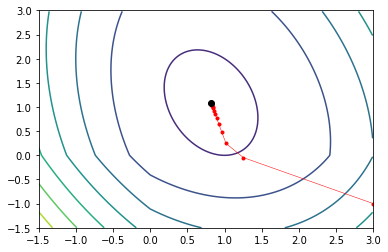

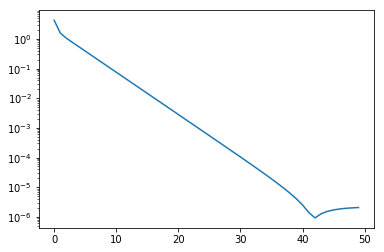

lambda: 4
cvx: [0.63635639 0.18185046]
PG: [0.63636364 0.18181815]


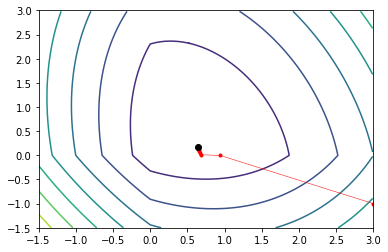

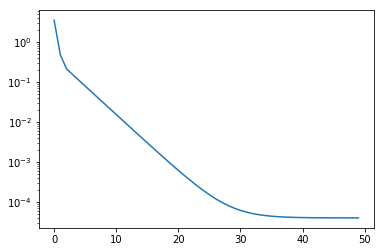

lambda: 6
cvx: [3.33114104e-01 5.00010424e-09]
PG: [0.33333333 0.        ]


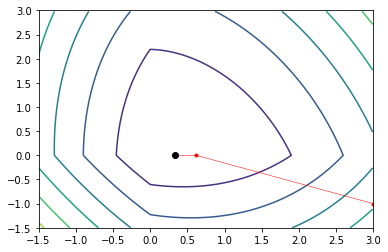

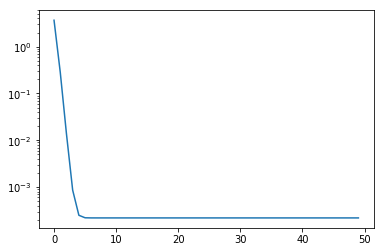

In [37]:
# hyper parameter
lam = 2
A = np.array([[3, 0.5],
                        [0.5, 1]])
mu = np.array([1,2])

w_init = np.array([[ 3],[-1]], dtype=np.float)
lip = 1.01 * np.max(np.linalg.eigvals(2 * A))  # 最大固有値
eta = 1/lip
numepoch = 50


# cvx
def calc_by_cvx(lam):
    w_lasso = cv.Variable(2)
    obj_fn = cv.quad_form((w_lasso - mu)[:, None], A) +  lam * cv.norm(w_lasso, 1)
    objective = cv.Minimize(obj_fn)
    constraints = []
    prob = cv.Problem(objective, constraints)
    result = prob.solve(solver=cv.CVXOPT) 
    return w_lasso.value

# proximal gradient method
def prox(w, q):
    w = w - w*(np.abs(w) <= q) - q*(w > q) + q*(w < -q)
    return w

def train(numepoch, w_init, A, mu, eta, lam):
    w_history = []
    wt = w_init
    for t in range(numepoch):
        w_history.append(wt.T)
        grad = 2 * np.dot(A, wt-mu[:, None])
        wt = wt - eta*grad
        wt = prox(wt, lam*eta)
    w_history = np.vstack(w_history)
    return w_history

# train
lams = [2, 4, 6]
for lam in lams:
    w_lasso = calc_by_cvx(lam)
    w_history = train(numepoch, w_init, A, mu, eta, lam)
    print(f'lambda: {lam}')
    print(f'cvx: {w_lasso}')
    print(f'PG: {w_history[-1]}')
    
    # plot contour
    X1, X2 = np.mgrid[-1.5:3:0.01, -1.5:3:0.02]
    X = np.stack([X1-mu[0], X2-mu[1]], axis=2)
    fValue = np.einsum('ijk, kl, ijl -> ij', X, A, X) + lam * (np.abs(X1) + np.abs(X2))
    plt.contour(X1, X2, fValue)

    # plot weight path and cv answer
    plt.plot(w_history[:,0], w_history[:,1], 'ro-', markersize=3, linewidth=0.5)
    plt.plot(w_lasso[0], w_lasso[1], 'ko', label='a')

    # show plot
    plt.xlim(-1.5, 3)
    plt.ylim(-1.5, 3)
    plt.show()
    
    # 
    plt.plot(np.sum(np.abs(w_history - w_lasso), axis=1))
    plt.yscale('log')
    plt.show()

## Group Lasso

In [39]:
# dataset 6
d_d6 = 200
n_d6 = 180

# we consider 5 groups where each group has 40 attributes
groupSize = 5
attrSize = 40
g_d6 = np.arange(groupSize*attrSize).reshape(groupSize,-1)

x_d6 = np.random.randn(n_d6, d_d6)
noise_d6 = 0.5

# we consider feature in group 1 and group 2 is activated.
w_d6 = np.vstack([20 * np.random.randn(80, 1),
                 np.zeros((120, 1)),
                 5 * np.random.rand()])
x_d6_tilde = np.hstack([x_d6, np.ones((n_d6, 1))])
y_d6 = np.dot(x_d6_tilde, w_d6) + noise_d6 * np.random.randn(n_d6, 1)

In [56]:
import cvxpy as cv
import matplotlib.pyplot as plt

def mldivide(A, b):
    piA = np.linalg.pinv(A)
    x = np.dot(piA, b)
    return x

# run the cell which preparing dataset 6 before run this cell
y = y_d6
x_tilde = x_d6_tilde
w = w_d6
noise = noise_d6
n = n_d6
d = d_d6
g = g_d6

lam = 1.0
wridge = mldivide(np.dot(x_tilde.T, x_tilde) + lam * np.eye(d+1), 
                  np.dot(x_tilde.T, y))

# cvx
west = cv.Variable((d+1,1))
obj_fn = \
  0.5 / n * cv.quad_form(x_tilde * west - y, np.eye(x_tilde.shape[0])) + \
  lam * (cv.norm(west[g[0]], 2.0) + \
         cv.norm(west[g[1]], 2.0) + \
         cv.norm(west[g[2]], 2.0) + \
         cv.norm(west[g[3]], 2.0) + \
         cv.norm(west[g[4]], 2.0) )
  
objective = cv.Minimize(obj_fn)
constraints = []

prob = cv.Problem(objective, constraints)
result = prob.solve(solver=cv.CVXOPT)

# test
x_test = np.random.randn(n, d)
x_test_tilde = np.hstack([x_test, np.ones((n, 1))])
y_test = np.dot(x_test_tilde, w) + noise * np.random.randn(n, 1)
y_pred = np.dot(x_test_tilde, west.value)
print(np.mean((y_pred - y_test)**2))

result

10.363723881189097


279.23537929570466

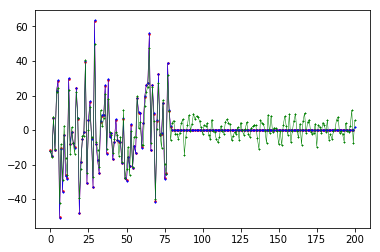

In [57]:
plt.plot(west.value[0:d], 'r-o', markersize=1.5, linewidth=0.5)
plt.plot(w, 'b-*', markersize=1.5, linewidth=0.5)
plt.plot(wridge, 'g-+', markersize=1.5, linewidth=0.5)

In [49]:
def prox(w, q):
    group_w = w[:,None]*g_fil
    l2norm = np.sqrt(np.sum(group_w**2, axis=0) / np.sum(g_fil, axis=0))
    return np.sum(np.fmax(0, g_fil*(1-q / l2norm)), axis=1) * w

def train(numepoch, w_init, X, Y):
    l_history = []
    w = w_init
    for t in range(numepoch):
        delta = np.dot(X, w) - Y
        loss = np.dot(delta, delta) / N + lam*np.sum(np.sqrt(np.sum((w[:,None]*g_fil)**2, axis=0)))/N
        grad = np.dot(X.T, delta) / N
        w -= eta*grad
        w = prox(w, lam*eta)
        l_history.append(loss)
    l_history = np.vstack(l_history)
    return l_history, w

# plot contour
X = x_d6_tilde
N, D = X.shape
Y = y_d6.reshape(-1)
w_init = np.random.randn(D)
numepoch = 1000
eta = 0.1
lam = 1

# proximal gradient method
g_fil = np.zeros((D, groupSize), dtype=bool)
for i in range(groupSize):
    g_fil[i*attrSize : i*attrSize+attrSize, i] = True

l_history, w = train(numepoch, w_init, X, Y)

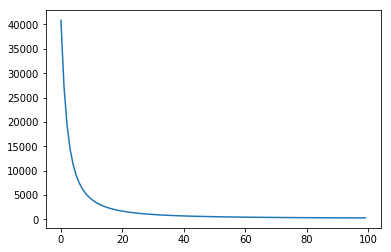

In [115]:
plt.plot(l_history)
plt.show()

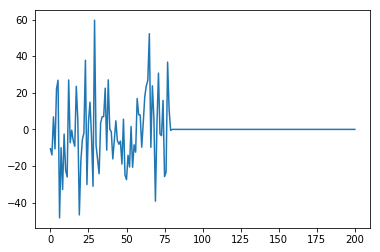

In [50]:
plt.plot(w)
plt.show()